# <img src = "../images/tutorial.png" width = "40"/> Skip-Gram Word2Vec Tutorial for Code - Switched Telugu - English Data
------------------------------------------------------------------------------------------------------------------------------------------------------

## <img src = "../images/presentation.png" width = "35"/> Introduction
------------------------------------------------------------------------------------------------------------------------------------------------------

### <img src = "../images/ai-modeling.png" width = "30"/> What is Word2Vec?

Word2Vec is a neural network based technique for learning vector representations of words, where semantically similar words are mapped close together in a vector space. One of its major algorithm is Skip-Gram. It aims to translate words into embedding vectors. These vectors are special in the way they capture the semantic relationships.


### <img src = "../images/algorithm.png" width = "30"/> What is Skip-Gram?

The Skip-Gram model is a neural network architecture used in Word2Vec to learn word embeddings based on the surrounding context of words. It captures semantic similarity and context in a low-dimensional vector space.

It aims at translating words to embedding vectors. The algorithm maps words to vectors based on the spatial proximity to other words. The assumption is, if the words are placed near they are semantically similar. It iterates over all words in the text input and optimizes vector representations distance based on the context.


### <img src = "../images/linguistics.png" width = "30"/> What is Code - Switching?

Code-Switching is the use of two or more languages within a single sentence or discourse. 

### <img src = "../images/language.png" width = "30"/> Why Telugu - English?

I am a native Telugu speaker. It would be useful for people like me who love to explore the code-switching between english as I use it in most of my communication online. It is also very popular in Indian digital platforms, particularly on YouTube adn social media. It presents uniqque challenges and opportunities for NLP.


### <img src = "../images/mission.png" width = "30"/> Purpose

This tutorial demonstrates how to build word embeddings using the Skip-Gram model for a Telugu-English dataset, enabling a cross-lingual understanding in a real-world scenario. Unlike traditional monolingual embeddings, this project focuses on the multilingual nature and informal structure of social media content.

## <img src = "../images/folder.png" width = "35"/> Environment Setup
------------------------------------------------------------------------------------------------------------------------------------------------------

To ensure that the tutorial works consistently across all systems without needing to install dependencies manually, I used Docker for a reproducible environment. Execute the following commands from the project root (i.e., the directory containing this README file) and select which files you want to work on.

To create a docker image by executing the following command:

docker build -t telugu_english_skipgram .

Once the image is built, run the container to access files.

To run the docker container, execute the following command:

docker run -it -p 7777:9999 -v "$PWD:/app/" telugu-english-skipgram

From within your Linux VM, open your browser to localhost:7777 to navigate through Project files.

## <img src = "../images/data-science.png" width = "35"/> Data Preparation
------------------------------------------------------------------------------------------------------------------------------------------------------

We need a clean and tokenized data for the Skip-Gram model to learn meaningful embeddings. This includes removing emojis, punctuations, any hyperlinks or links to other videos and preparing text.

### <img src = "../images/youtube.png" width = "30"/> Dataset

I have extracted comments from 30 Youtube videos. These videos range from movie songs to pre-release events, reality shows to teasers, national issues to cooking videos. 

I have used "YoutubeCommentDownloader" package for this purpose.

To see how I collected data and what all videos I have used, refer to the "scripts/Youtube Scaraping.ipynb" file.

Snippet of code to extract comments from a video:

In [1]:
from youtube_comment_downloader import YoutubeCommentDownloader
import pandas as pd

dwnldr = YoutubeCommentDownloader()

video_urls = ["https://www.youtube.com/watch?v=iJF9AHeZVao"]

comments_list = []
counter = 1

for video in video_urls:
    for comment in dwnldr.get_comments_from_url(video, sort_by = 0):
        comments_list.append(comment["text"])
    print("Downloaded comments for a video")
    counter += 1

Downloaded comments for a video


I saved this data into "data/comments.txt".

### <img src = "../images/business-model.png" width = "30"/> Text Cleaning

The comments contained various emojis, unwanted characters, and links to other videos which I carefully processed. Initially I used packages to clean them. Using this approach I was still left with some more unwanted emojis. Hence, I defined those emojis and a function to remove them. 

You can refer to the "scripts/Skipgram Model.ipynb" file for detailed implementation.

Snippet for cleaning the data is as follows:

In [2]:
import re
import emoji

def clean_comments(text):
    unclean_data = re.compile("["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U00002700-\U000027BF"u"\U000024C2-\U0001F251""]+", flags = re.UNICODE)

    text = unclean_data.sub(r"", text)

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)

    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    text = re.sub(r"\d+", "", text)

    text = re.sub(r"\s+", " ", text).strip()

    text = emoji.replace_emoji(text, replace = "")

    return text

In [3]:
def cleaning_emojis(tokens):
    unwanted_emojis = ["🥰", "🤣", "🤗", "🤣🤣", "🤣🤣🤣", "🥰🥰", "🤩", "🤔", "🚩", "🤝", "🤦", "🫂", "🥰🥰🥰", "🤣🤣🤣🤣🤣", "🤣🤣🤣🤣", "🤦\u200d", "🤷\u200d", "🤔🤔🤔", "🤞", "🤌", "🥺", "🤤🤤", "🤡", "\u200d\u200d", "🥰🥰🥰🥰🥰🥰", "🥲", "🤩🤩", "🫂🫂", "🥲\U0001f979", "🚩🚩", "🤩🥰", "🧡🤍", "🤯", "\u200d🩹", "🤘", "🤦\u200d🤦\u200d🤦\u200d", "🤤", "🥰🥰🥰🥰", "🧠"]

    return [t for t in tokens if t not in unwanted_emojis]

To tokenise the comments, I have used the following snippet of code:

In [4]:
import string
from nltk.tokenize import word_tokenize

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[" + string.punctuation + "]", "", text)
    tokens = word_tokenize(text)

    return tokens

## <img src = "../images/3d-model.png" width = "35"/> Skip-Gram Model with Gensim
------------------------------------------------------------------------------------------------------------------------------------------------------

### <img src = "../images/training.png" width = "30"/> Training Model

This is the core step of the project. This is where we learn the vector representation of words that capture semantic meaning. We have used the Word2Vec technique for this.

Word2vec works on few parameter:

- vector_size: embedding dimensionality
- window: context window size
min_count: minimum word frequency
-sg: for a skip-gram model we assign a value 1, for a count bag of words model we use 0
- workers: number of training threads
- epochs: training iterations over corpus

The snippet of code for parameters I used in my project:

In [6]:
from gensim.models import Word2Vec

with open("../data/cleaned_comments.txt", "r", encoding = "utf-8") as f:
    comments = f.readlines()

cleaned_comments = [word_tokenize(l.strip()) for l in comments if l.strip()]

skipgram_model = Word2Vec(sentences = cleaned_comments,
                          vector_size = 1000,
                          window = 5,
                          min_count = 2,
                          sg = 1,
                          workers = 4,
                          epochs = 10)

I have saved the cleaned and tokenised data into the data folder under the name "cleaned_comments.txt".

### <img src = "../images/exploration.png" width = "30"/> Exploring Embeddings

To inspect how well the model has learned word relationships, I checked for similar words and their similarity score. I have also represneted it as an embedding visual with PCA.

Snippet of code for visualisaing and examining top 5 similar words is as follows:

Words similar to skit:
athayya: 0.9974
clothes: 0.9971
bokkala: 0.9957
madhi: 0.9957
colour: 0.9955


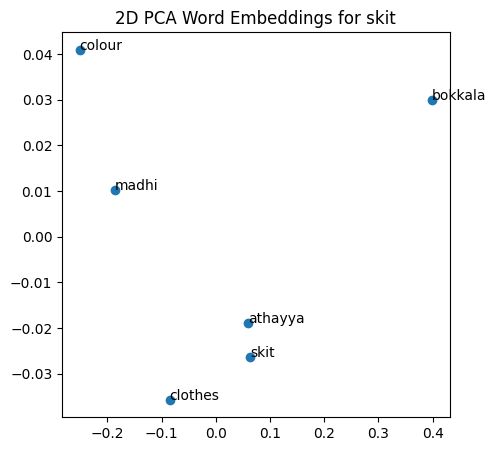

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualise_word_embeddings(word):

    similar_words = skipgram_model.wv.most_similar(word, topn = 5)

    print(f"Words similar to {word}:")

    for w, s in similar_words:
        print(f"{w}: {s:.4f}")

    words = [w for w,s in similar_words]
    vectors = [skipgram_model.wv[w] for w in words]

    words.insert(0, word)
    vectors.insert(0, skipgram_model.wv[word])

    pca = PCA(n_components = 2)
    res = pca.fit_transform(vectors)

    plt.figure(figsize = (5, 5))
    plt.scatter(res[:, 0], res[:, 1])

    for i, w in enumerate(words):
        plt.annotate(w, xy = (res[i, 0], res[i, 1]))

    plt.title(f"2D PCA Word Embeddings for {word}")
    plt.show()


visualise_word_embeddings("skit")

I have checked the word embeddings for the word skit. We observed similar words like chesukunnaru (they did), download, kontha (some), atthayya (aunt), unai (present). It made complete sense as for an english word skit, the word embeddings revealed sentences like they did a skit, download skit, there are some skits to be presented, etc.

### <img src = "../images/save.png" width = "30"/> Saving the Model

To reuse the trained embeddings later without retrining, used the following snippet of code:

In [ ]:
skipgram_model.save("../model/telugu_english_skipgram.model")